## 0. Data download and extract

In [1]:
!mkdir -p images/metadata

!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar -O images/metadata/abo-images-small.tar
!tar -xf images/metadata/abo-images-small.tar -C images/metadata/
!rm images/metadata/abo-images-small.tar

--2025-11-16 14:39:15--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Translacja amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 52.217.142.217, 54.231.193.145, 52.217.121.225, ...
Łączenie się z amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|52.217.142.217|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 3253381120 (3,0G) [application/x-tar]
Zapis do: ‘images/metadata/abo-images-small.tar’

mages-small.tar      13%[=>                  ] 432,98M  15,4MB/s    eta 3m 0s  ^C
tar: Nieoczekiwany EOF w archiwum
tar: Nieoczekiwany EOF w archiwum
tar: Error is not recoverable: exiting now


In [ ]:
!mv images/metadata/images/* images/metadata/
!mv images/metadata/metadata/images.csv.gz images/metadata/
!rm -rf images/metadata/images
!rm -rf images/metadata/metadata

mv: nie można wykonać stat na 'images/metadata/images/*': Nie ma takiego pliku ani katalogu


In [ ]:
!gzip -d images/metadata/images.csv.gz

## 1. Extract paths and filter data

In [2]:
import pandas as pd

imgs = pd.read_csv('images/metadata/images.csv')
imgs = imgs[(imgs['height'] >= 1000) & (imgs['width'] >= 1000)]
paths = imgs['path'].tolist()

In [3]:
paths

['46/4689906d.png',
 '0c/0cd7596c.jpg',
 'e6/e602a9af.jpg',
 'e7/e7cfeb02.jpg',
 '68/6839db4e.jpg',
 '01/013ffa0b.jpg',
 '07/07d70c78.jpg',
 '15/15e97f5f.jpg',
 '0d/0d0d4a48.jpg',
 '55/5584aeeb.jpg',
 '19/1908ea80.jpg',
 '4b/4b7250f0.jpg',
 'a1/a170e8a8.jpg',
 '59/59ef1a00.jpg',
 '2e/2ef02f76.jpg',
 '75/7527736c.jpg',
 '30/30e92b64.jpg',
 '1a/1a02ed5e.jpg',
 'd0/d066cc1f.jpg',
 'f8/f886a665.jpg',
 '41/414130f4.jpg',
 '2e/2e5e3a0b.jpg',
 '82/828ba800.jpg',
 '99/99ac32dc.jpg',
 'c1/c114d6fd.jpg',
 '40/403cd415.jpg',
 'f4/f4422f00.jpg',
 'a2/a25844c4.jpg',
 '66/6639774e.jpg',
 '62/62d40282.jpg',
 '7d/7dda69d6.jpg',
 'c2/c2fdf416.jpg',
 'd7/d7b06227.jpg',
 '41/41fda343.jpg',
 '87/8786ba56.jpg',
 'ab/ab1e9d7e.jpg',
 '37/37d997bb.jpg',
 'a7/a7ea04f4.jpg',
 '97/97680781.jpg',
 '55/55c4ae93.jpg',
 '7c/7cac720b.jpg',
 'a6/a62534dd.jpg',
 '97/974a66a6.jpg',
 '92/921539b5.jpg',
 'd9/d934b97e.jpg',
 'c4/c40ab47c.jpg',
 '87/871a7224.jpg',
 '06/0616d610.jpg',
 '9e/9e575223.jpg',
 '95/95f07bc7.jpg',


## 2. Model selection

### 2.1. Check embedding size

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('clip-ViT-B-32')

embeddings = model.encode(paths[0])
print(f"Embeddings shape: {embeddings.shape[0]}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Embeddings shape: 512


### 2.2. Model nomenclature

* **ViT** - Vision Transformer
* **B** - base size. Other possible sizes are for example Ti(Tiny), L, H(Huge) etc.
* **32** - patch size - e.g. if patch size = 32, images is divided for 32x32 patches

## 3. DB setup

In [5]:
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
from sqlalchemy.engine import URL
from typing import List
from sqlalchemy import String
from pgvector.sqlalchemy import Vector
class Base(DeclarativeBase):
    __abstract__ = True

class Img(Base):
    __tablename__ = "images"
    __table_args__ = {'extend_existing': True}
    
    VECTOR_LENGTH: int = 512 # implement me!
    
    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(128))
    image_embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))
    

Used db from lab task; docker compose from vectorscale_db folder

In [6]:
db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5557,
    database="similarity_search_service_db"
)

In [7]:
from sqlalchemy import create_engine

engine = create_engine(db_url)
Base.metadata.create_all(engine)

## 4. Img vectorization

In [ ]:
import joblib
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from sqlalchemy.orm import Session
from more_itertools import batched
import os
image_paths = paths
image_paths = ["images/metadata/small/" + p for p in image_paths]
image_paths = [p for p in image_paths if os.path.exists(p)]
MAX_IMAGES = 50000 # Limited due to resource constraints
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

def insert_images(engine, images):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()

def vectorize_images(engine, model, image_paths):    
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in batched(image_paths[:MAX_IMAGES], BATCH_SIZE):  # finish (suggestion - use `batched`)

            images = [Image.open(p).convert("RGB") for p in images_paths_batch]

            embeddings = model.encode(images, convert_to_numpy=True, show_progress_bar=False)

            objs = [
                Img(image_path=path, image_embedding=embedding)
                for path, embedding in zip(images_paths_batch, embeddings)
            ]

            insert_images(engine, objs)

            pbar.update(len(images_paths_batch))

vectorize_images(engine, model, image_paths)

  0%|          | 0/50000 [00:00<?, ?it/s]

## 5. Search and display

In [ ]:
import matplotlib.pyplot as plt
from sqlalchemy import text

class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model
        
    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        img_paths = [row.image_path for row in found_images]
        self.display_images(img_paths)
    
    def find_similar_images(self, image_description: str, k: int):
        emb = self.model.encode(image_description, convert_to_numpy=True).tolist()

        sql = text("""
            SELECT image_path, image_embedding <=> (:embedding)::vector AS distance
            FROM images
            ORDER BY distance ASC
            LIMIT :k;
        """)
        
        with Session(self.engine) as session:
            result = session.execute(sql, {"embedding": emb, "k": k}).all()

        return result
    
    def display_images(self, images):
        k = len(images)

        _, axes = plt.subplots(1, k, figsize=(4*k, 5))

        if k == 1:
            axes = [axes]
        for i, img_path in enumerate(images):
            img = Image.open(img_path).convert("RGB")
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(i+1)

        plt.tight_layout()
        plt.show()


#### **MAX_IMAGES** = 50 000

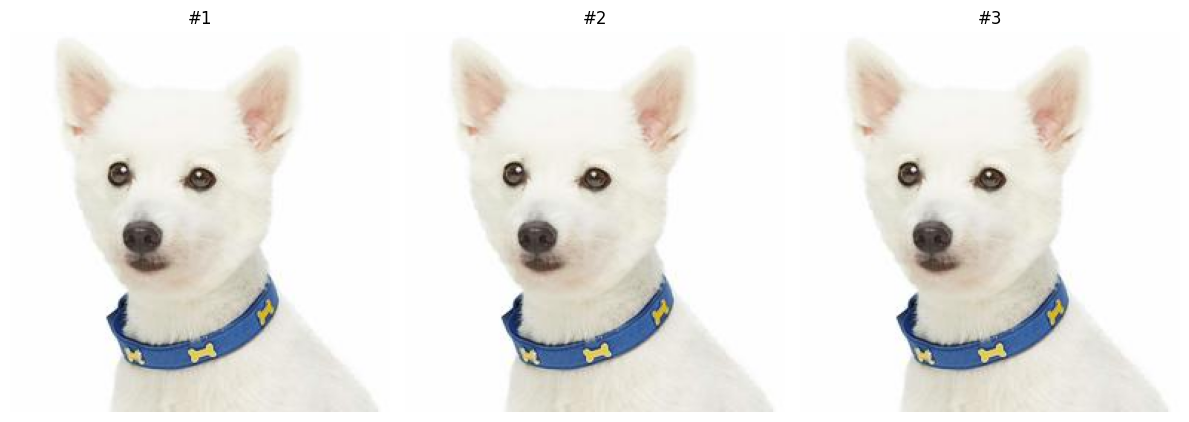

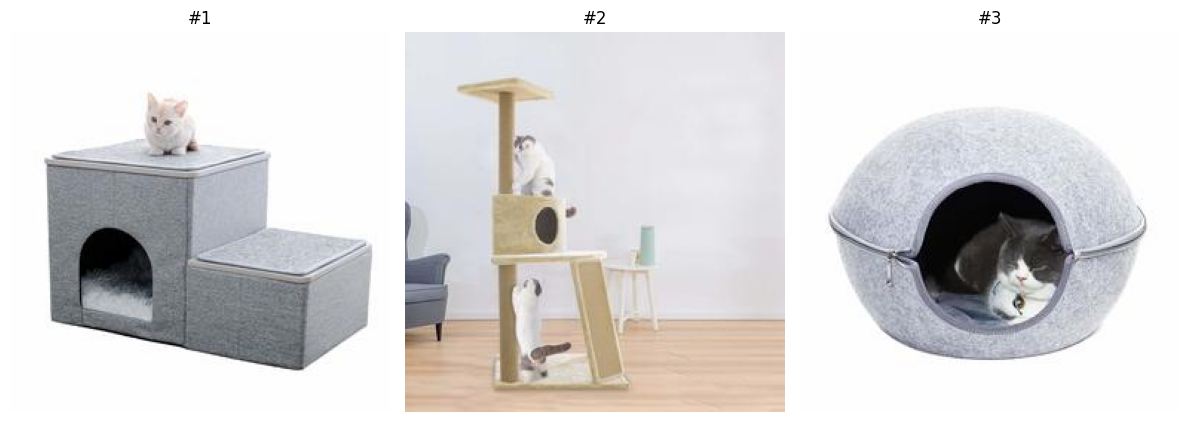

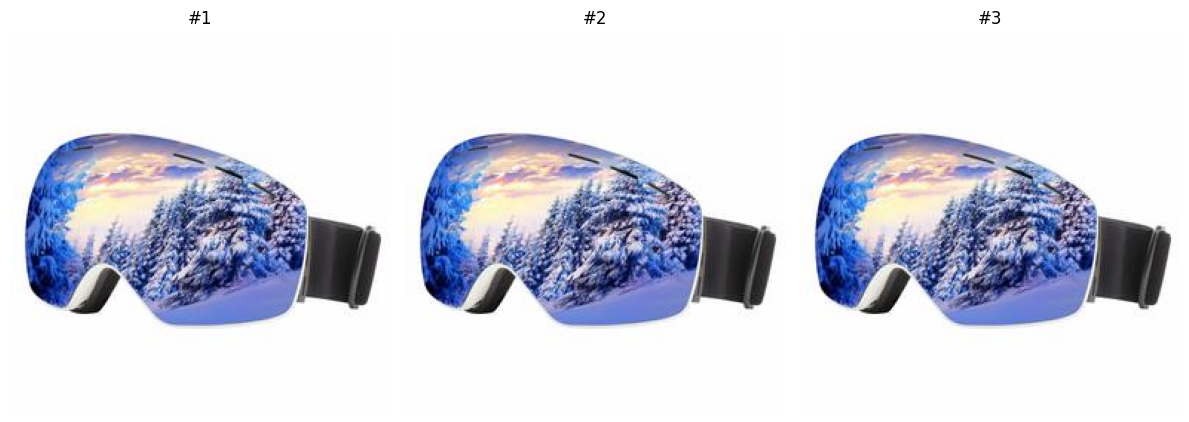

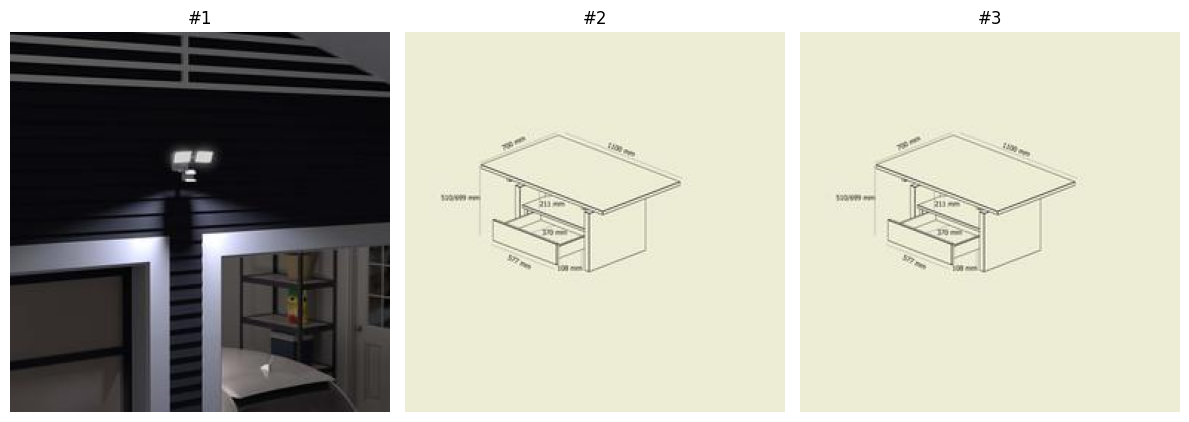

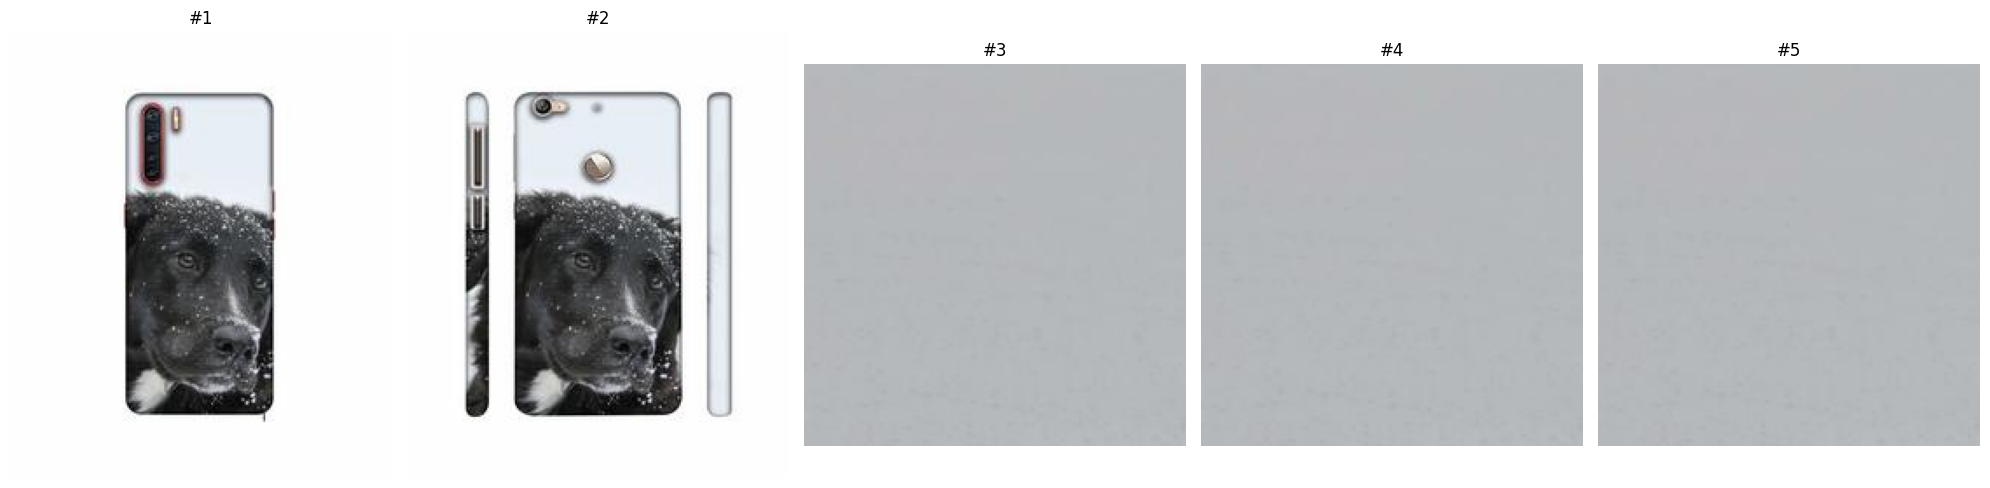

In [26]:
search = ImageSearch(engine, model)
search("dog", 3)
search("cat", 3)
search("winter forest", 3)
search("small house", 3)
search("A cute dog in snow", k=5)

#### We can see that results are more or less reasonable. Let's compare a quality of search for different datasets sizes

#### **MAX_IMAGES = 2500**

In [29]:
def clear_database(engine):
    with Session(engine) as session:
        session.execute(text("DELETE FROM images;"))
        session.commit()

  0%|          | 0/2500 [00:00<?, ?it/s]

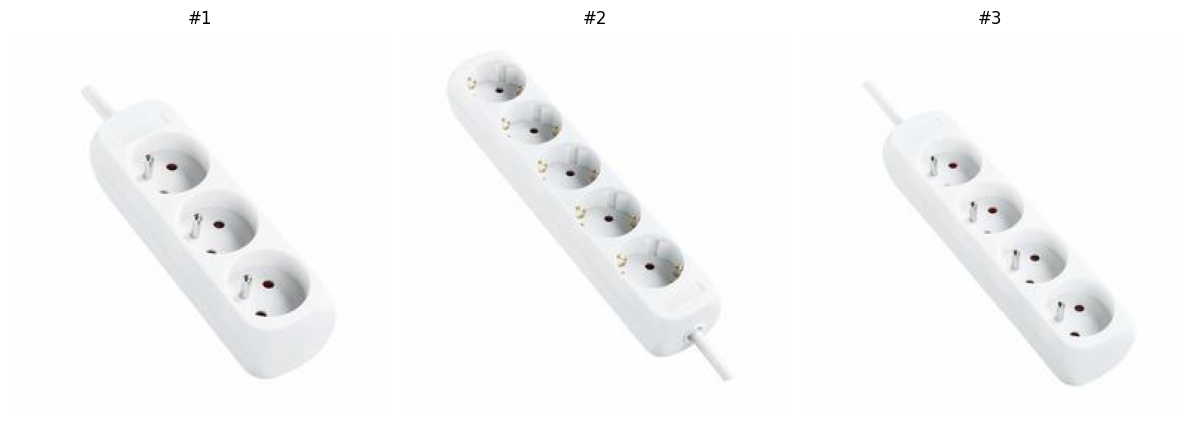

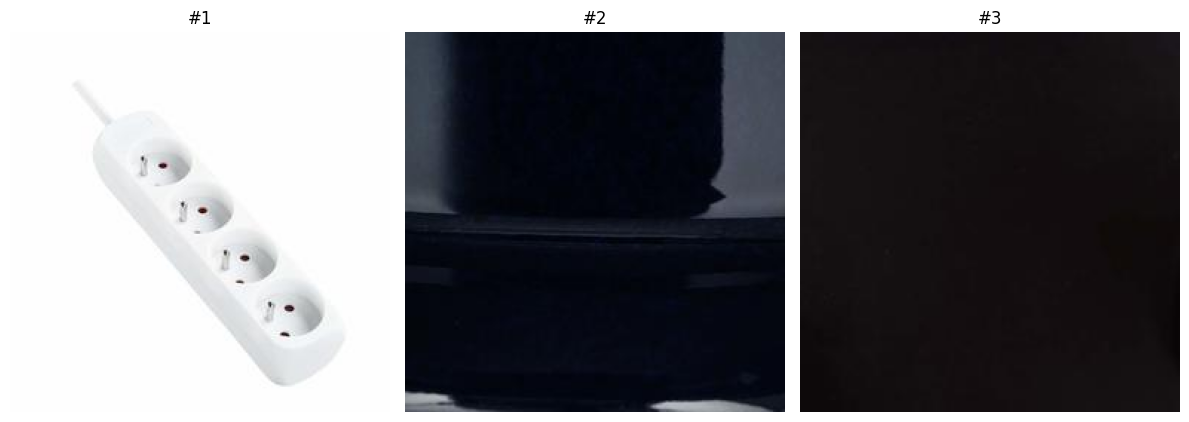

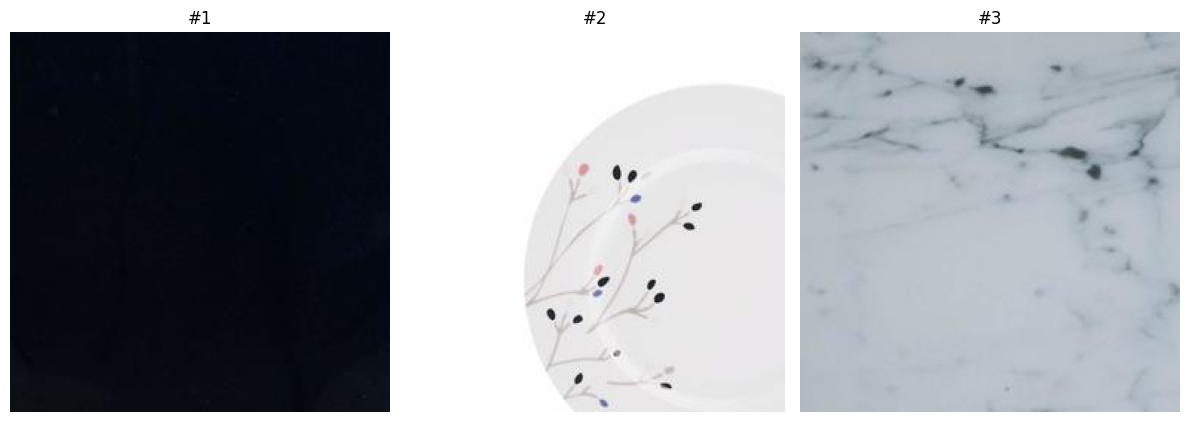

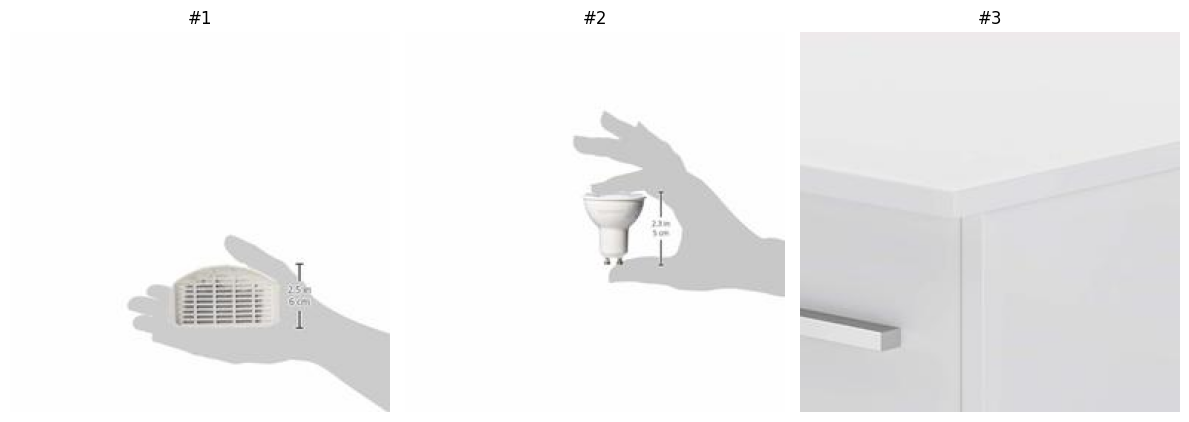

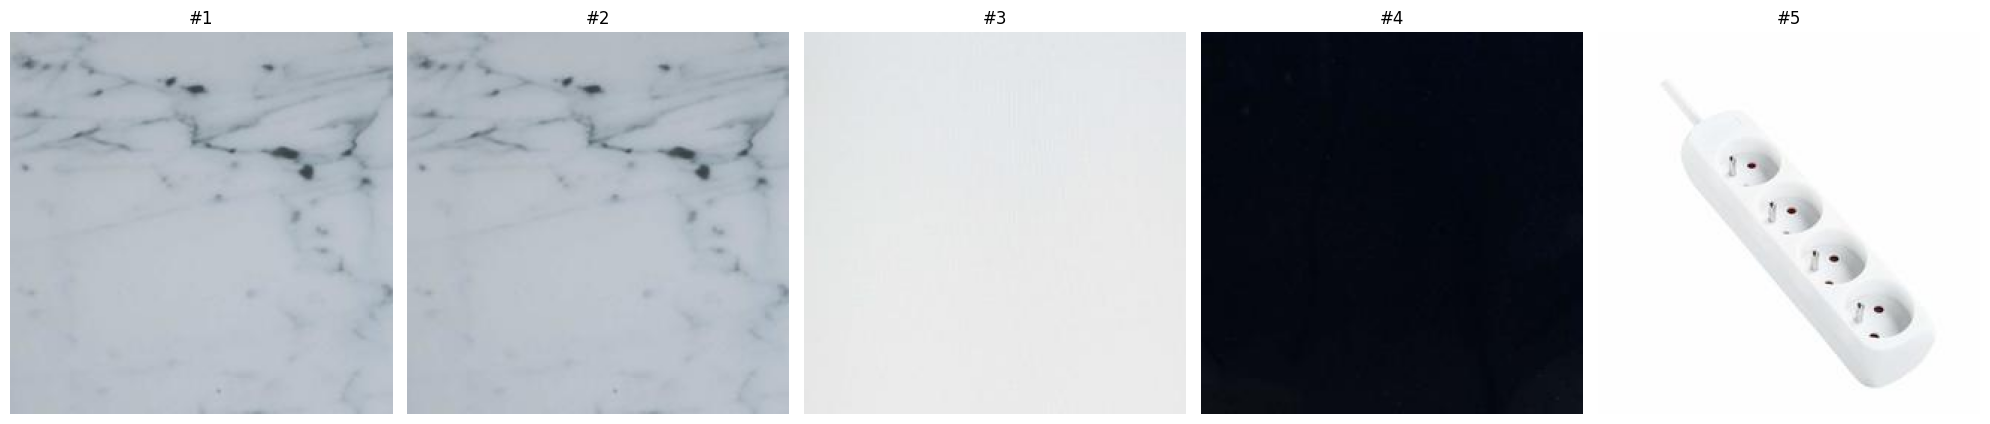

In [31]:
MAX_IMAGES = 2500
clear_database(engine)
vectorize_images(engine, model, image_paths)
search = ImageSearch(engine, model)

search("dog", 3)
search("cat", 3)
search("winter forest", 3)
search("small house", 3)
search("A cute dog in snow", k=5)

#### **MAX_IMAGES** = 10000

  0%|          | 0/10000 [00:00<?, ?it/s]

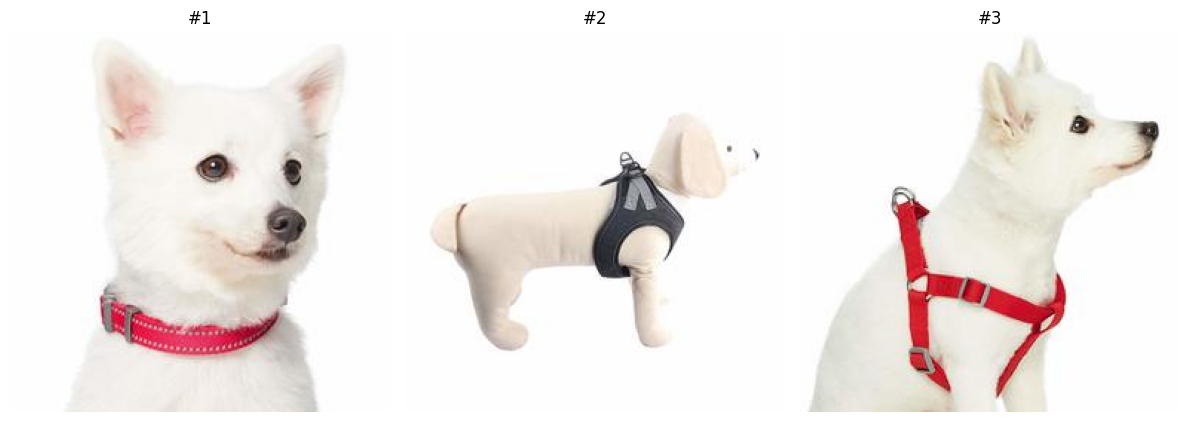

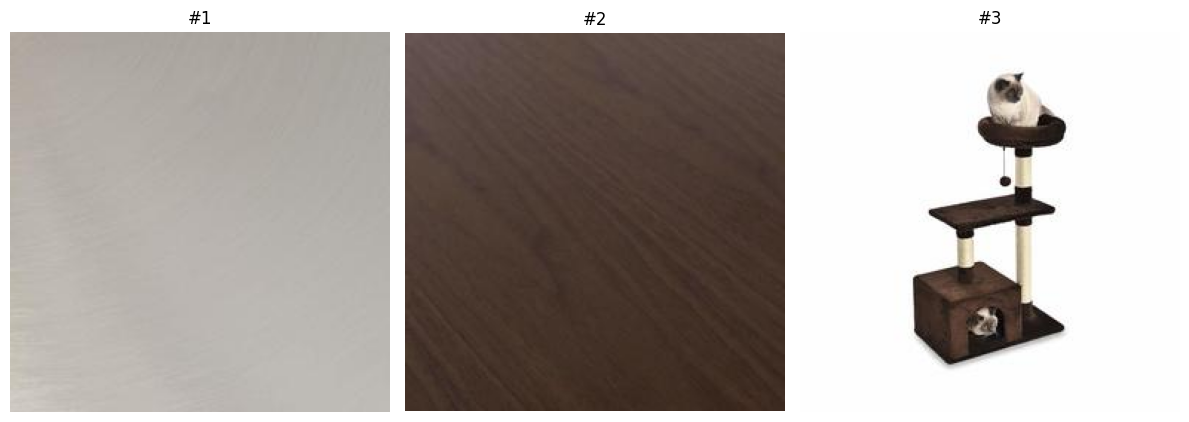

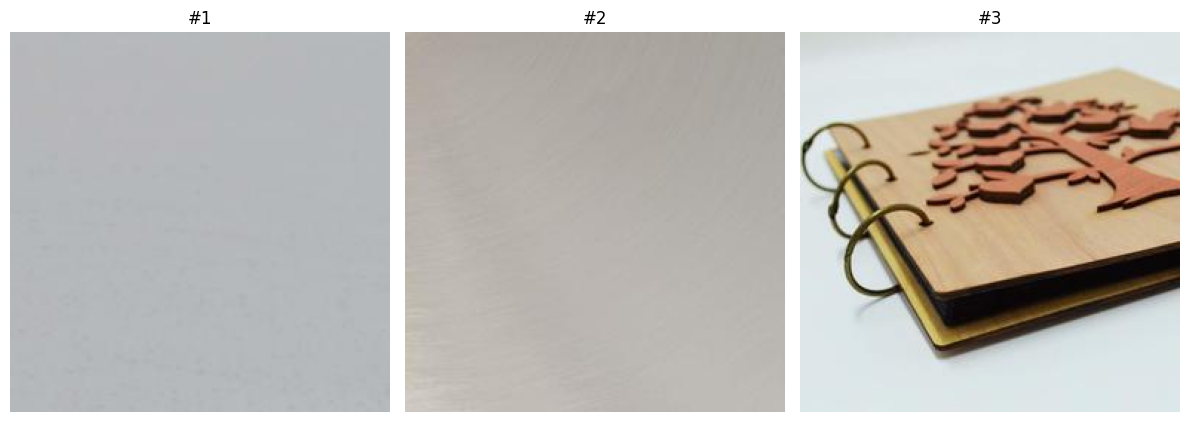

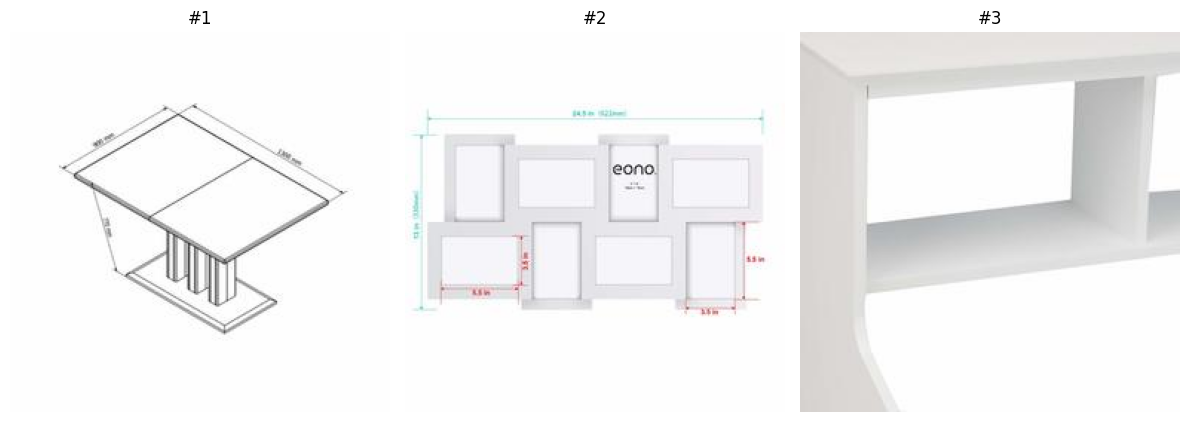

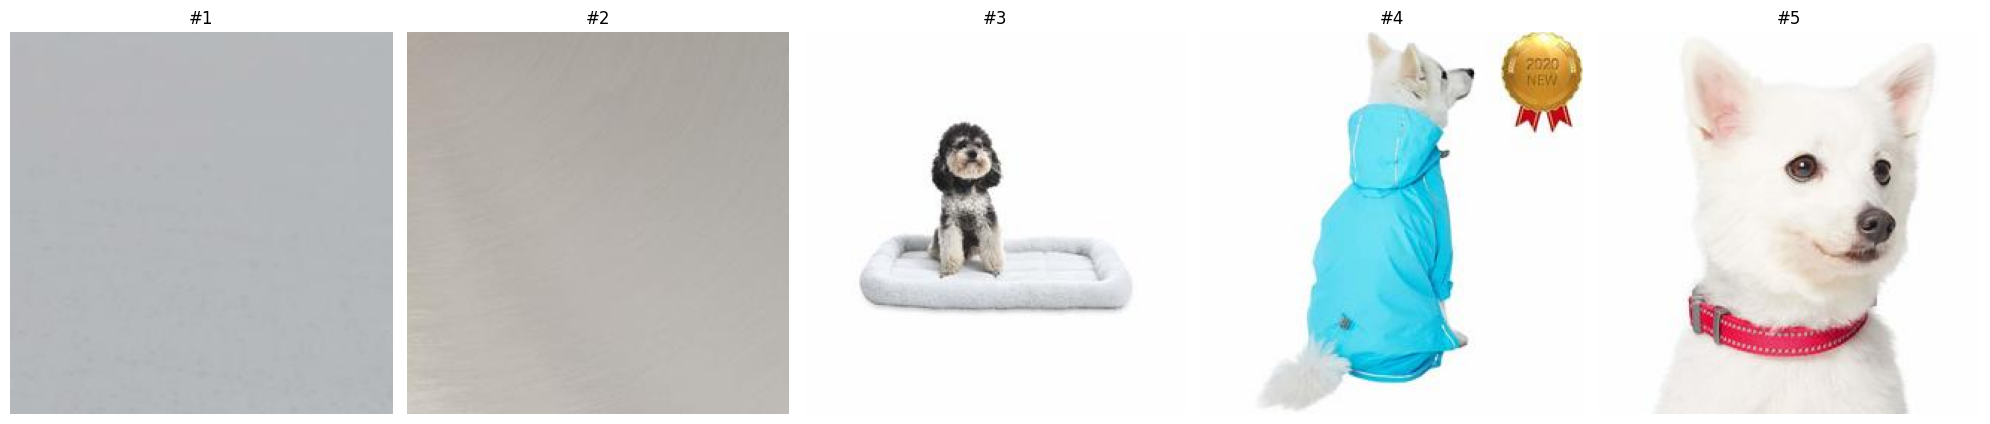

In [32]:
MAX_IMAGES = 10000
clear_database(engine)
vectorize_images(engine, model, image_paths)
search = ImageSearch(engine, model)

search("dog", 3)
search("cat", 3)
search("winter forest", 3)
search("small house", 3)
search("A cute dog in snow", k=5)

#### As we can see above, dataset size highly impacts search results